### rank analysis

answer the questions:

1. any trend in the rank over laps observable?


# Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


## Load Data

In [2]:
import os
os.getcwd()


'/scratch/hpda/indycar/predictor/notebook/3.StageDataset'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
event = 'Indy500'

inputfile = '../data/raw/C_'+ event +'-' + year + '-final.csv'
outputprefix = year +'-' + event + '-'
dataset = pd.read_csv(inputfile)
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18500 entries, 0 to 18499
Data columns (total 21 columns):
rank                    18500 non-null int64
car_number              18500 non-null int64
unique_id               18500 non-null object
completed_laps          18500 non-null int64
elapsed_time            18500 non-null float64
last_laptime            18500 non-null float64
lap_status              18500 non-null object
best_laptime            18500 non-null float64
best_lap                18500 non-null object
time_behind_leader      18500 non-null float64
laps_behind_leade       18500 non-null object
time_behind_prec        18500 non-null float64
laps_behind_prec        18500 non-null object
overall_rank            18500 non-null object
overall_best_laptime    18500 non-null float64
current_status          18500 non-null object
track_status            18500 non-null object
pit_stop_count          18500 non-null object
last_pitted_lap         18500 non-null object
start_position

In [4]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
    
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    
    return df

def make_lapstatus_data(dataset):
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)
    
    #pick up one of them
    onecar = dataset[dataset['car_number']==completed_car_numbers[0]]
    onecar = onecar.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    return onecar[['completed_laps','track_status']]
    

In [5]:
final_lap = max(dataset.completed_laps)
total_laps = final_lap + 1

# get records for the cars that finish the race
completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
completed_car_count = len(completed_car_numbers)

print('count of completed cars:', completed_car_count)
print('completed cars:', completed_car_numbers)

#make a copy
alldata = dataset.copy()
dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]


In [6]:
cldata = make_cl_data(dataset)
#cldata.to_csv(outputprefix + 'completed_laps_diff.csv')

flagdata = make_lapstatus_data(dataset)
#flagdata.to_csv(outputprefix + 'flagstatus.csv')

acldata = make_cl_data(alldata)
#cldata.to_csv(outputprefix + 'all_completed_laps_diff.csv')

cars: {64, 1, 66, 98, 4, 6, 9, 12, 60, 15, 20, 22, 23, 88, 25, 27, 28, 29}
#cars= 18
count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]
cars: {1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98}
#cars= 33


/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### overall view of laptime scatter plots



In [32]:
def get_cardata(curcarno, ycol='time_diff'):
    car = acldata[acldata['car_number']==curcarno]
    #print(car['time_diff'].describe())
    
    cols=['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']
    colid={key:idx for idx, key in enumerate(cols)}

    cardata = rankdata[rankdata['car_number'] == curcarno]

    carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
        ['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']].values]
    
    x = car['completed_laps'][1:].values
    y = car[ycol][1:].values

    pits=[]
    yellowflags=[]
    lastflag = 'x'
    for row in carstatus:
        lap = int(row[colid['completed_laps']])

        if row[colid['lap_status']]=='P':
            pits.append(lap)

        if row[colid['track_status']]=='Y':
            if lastflag != 'Y':       
                #start
                yellowflags.append(lap)
        else:
            if lastflag == 'Y':       
                #end
                yellowflags.append(lap)        
        lastflag = row[colid['track_status']]

    #pit lap
    pits = np.array(pits)
    #start, end lap
    #
    yellowflags = np.array(yellowflags)
    if (yellowflags.shape[0] % 2)==1:
        print('crash?:carno=', curcarno)
        yellowflags = []
    else:
        yellowflags = np.array(yellowflags).reshape((-1,2))    
    
    return car, x, y, pits, yellowflags

In [23]:
def draw_laptime(ax, ycol='LapTime'):
    
    ymax = np.max(y)
    
    #yellow flags
    for yflag in yellowflags:
        ax.bar(yflag[0],ymax, width = yflag[1] - yflag[0], align='edge', color = 'y', zorder=-100)

    #plt.plot(np.arange(laptime.shape[0]), laptime, marker='.')
    ax.scatter(x, y, marker='.')    

    #pit stops    
    ax.scatter(pits, y[pits-1], marker='x', color='r')
    for pit in pits:
        ax.bar(pit,height = y[pits-1], width = .8, align='center', color = 'r', zorder=-100)
    
    #ax.set_xlim((0, 33))
    #ax.set_ylim((0, 201))
    ax.set_xlabel('Lap')
    ax.set_ylabel(ycol)
    
def draw_pitstop(ax, pits):
    #pit stops    
    ax.scatter(pits, y[pits-1], marker='x', color='r')
    for pit in pits:
        ax.bar(pit,height = y[pits-1], width = .8, align='center', color = 'r', zorder=-100)

    
def draw_yellowflag(ax,yellowflags):
    ymax = np.max(y)
    #yellow flags
    for yflag in yellowflags:
        ax.bar(yflag[0],ymax, width = yflag[1] - yflag[0], align='edge', color = 'y', zorder=-100)

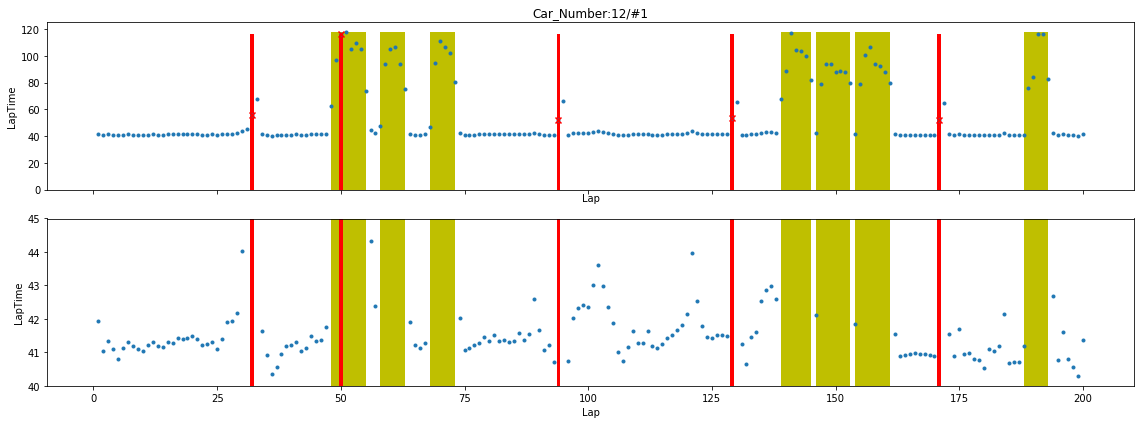

In [12]:
curcarno=12
car, x, y, pits, yellowflags = get_cardata(curcarno)


fig, axes = plt.subplots(2,sharex=True,figsize=(16,6))

draw_laptime(axes[0])
axes[1].set_ylim((40, 45))
draw_laptime(axes[1])


#ax.set_aspect('equal')
finalrank = car['rank'].values[-1]
axes[0].set_title('Car_Number:%d/#%d'%(curcarno, finalrank))
fig.tight_layout()

In [ ]:
yellowflags

In [ ]:
pits

### rank plots

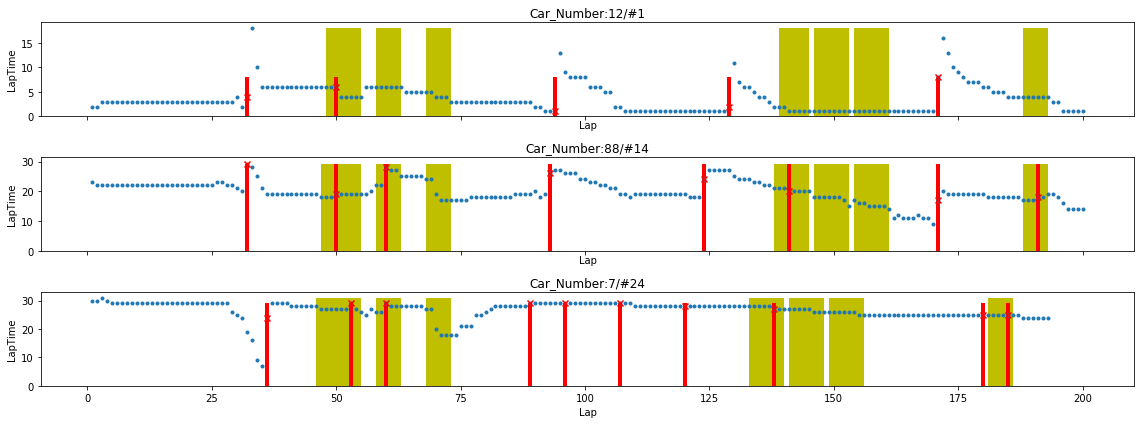

In [13]:
#
# rank plots
#


fig, axes = plt.subplots(3,sharex=True,figsize=(16,6))
#fig.set_size_inches(15,8)
curcarno=12
car, x, y, pits, yellowflags = get_cardata(12,'rank')
draw_laptime(axes[0])
finalrank = car['rank'].values[-1]
axes[0].set_title('Car_Number:%d/#%d'%(curcarno, finalrank))

curcarno=88
car, x, y, pits, yellowflags = get_cardata(curcarno,'rank')
draw_laptime(axes[1])
finalrank = car['rank'].values[-1]
axes[1].set_title('Car_Number:%d/#%d'%(curcarno, finalrank))

curcarno=7
car, x, y, pits, yellowflags = get_cardata(curcarno,'rank')
draw_laptime(axes[2])
finalrank = car['rank'].values[-1]
axes[2].set_title('Car_Number:%d/#%d'%(curcarno, finalrank))


#axes[1].set_ylim((40, 45))
#draw_laptime(axes[1])


#ax.set_aspect('equal')
#axes[0].set_title('Car_Number:%d'%curcarno)
fig.tight_layout()
#fig.savefig(outputprefix + '_laptime-%d.pdf'%curcarno)

### rank in group view

In [26]:
def get_grouprank(carlist, ycol='time_diff'):
    ret = []
    for carno in carlist:
        #car = acldata[acldata['car_number']==carno]
        #x = car['completed_laps'][1:].values
        #y = car[ycol][1:].values
        
        car, x, y, pits, yellowflags = get_cardata(carno,'rank')
        
        ret.append((x,y,pits))
        
    return ret, yellowflags



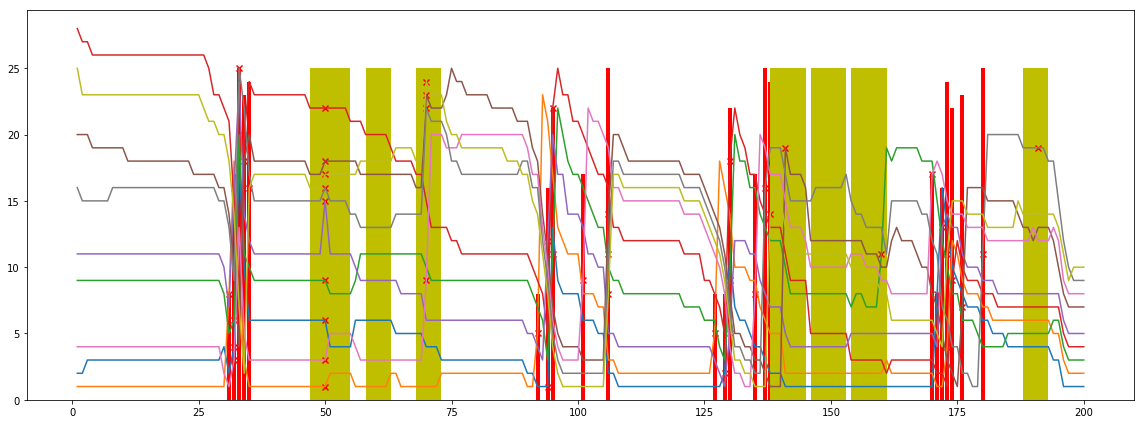

In [27]:
finalgroup = [12, 20, 9, 27, 28, 29, 1, 6, 15]
startgroup = [20, 22, 12, 1, 18, 21, 13, 3, 9, 14]

finals, yellowflags = get_grouprank(finalgroup,'rank')

fig, axes = plt.subplots(1,figsize=(16,6))
for x, y,pits in finals:
    axes.plot(x,y)
    draw_pitstop(axes, pits)
    
draw_yellowflag(axes,yellowflags)
    
fig.tight_layout()

crash?:carno=%d 3


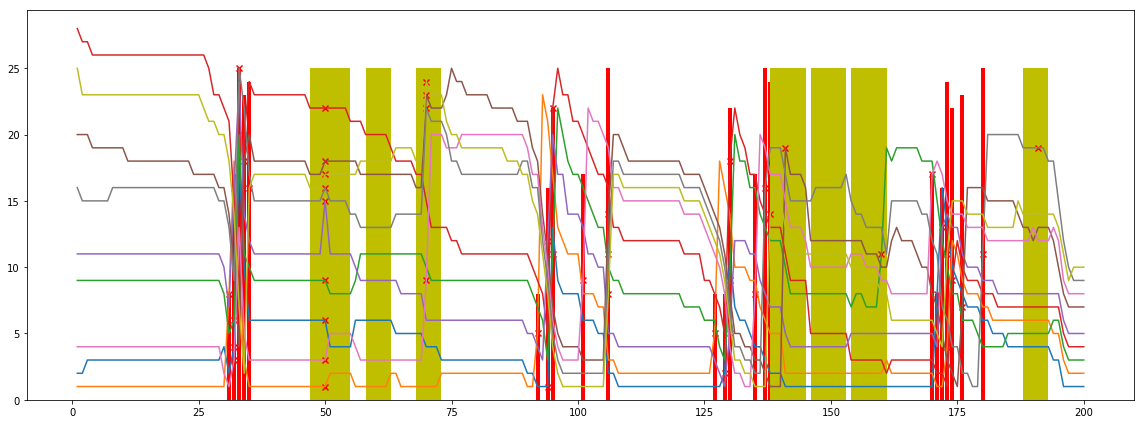

In [33]:
finals
get_grouprank(startgroup,'rank')

fig, axes = plt.subplots(1,figsize=(16,6))
for x, y,pits in finals:
    axes.plot(x,y)
    draw_pitstop(axes, pits)
    
draw_yellowflag(axes,yellowflags)
    
fig.tight_layout()

### conclusions

+ rank in group view, either the final top 10 group or the start top 10 group, shows relatively stable in non-pit and non-yellowflag area